### 0. Standard setup for logging and plotting inside a notebook

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
root = logging.getLogger()
root.addHandler(logging.StreamHandler())
%matplotlib inline

### 1. Choose a representative species for a case study

In [2]:
# download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCOFNiUHYwcVFVODQ
# Representative example with multiple polygons in the shapefile, and a lot of point-records (also outside rangemaps)
from iSDM.species import IUCNSpecies
salmo_trutta = IUCNSpecies(name_species='Salmo trutta')
salmo_trutta.load_shapefile("../data/fish/selection/salmo_trutta")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/salmo_trutta
The shapefile contains data on 3 species areas.


### 2. Rasterize the species, to get a matrix of pixels

In [3]:
rasterized = salmo_trutta.rasterize(raster_file="./salmo_trutta_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./salmo_trutta_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


#### 2.1 Plot to get an idea

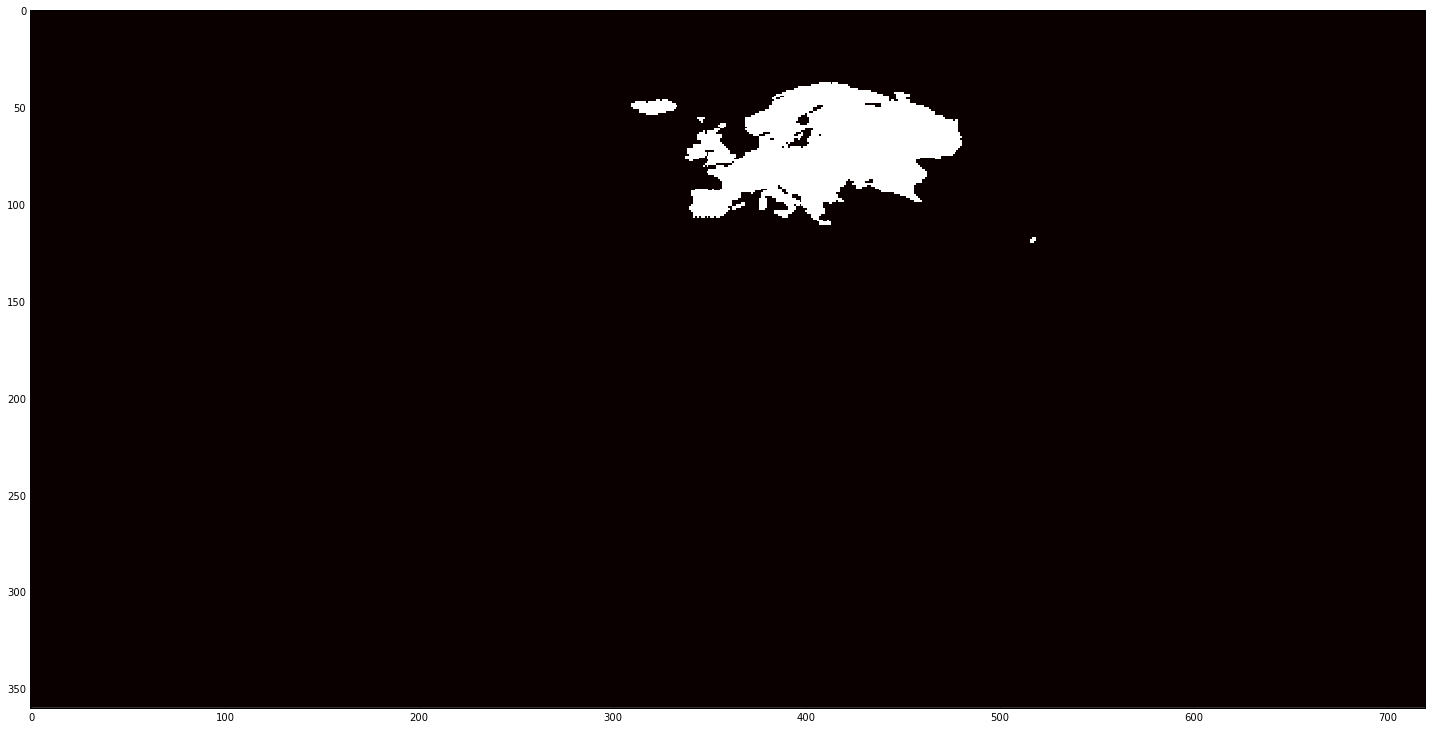

In [4]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized, cmap="hot", interpolation="none")

### 3. Load the biogeographical regons raster layer

In [5]:
from iSDM.environment import RasterEnvironmentalLayer
biomes_adf = RasterEnvironmentalLayer(file_path="../data/rebioms/w001001.adf", name_layer="Biomes")
biomes_adf.load_data()

Loaded raster data from ../data/rebioms/w001001.adf 
Driver name: AIG 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'AIG',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 255.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.


<open RasterReader name='../data/rebioms/w001001.adf' mode='r'>

#### 3.1 Plot to get an idea

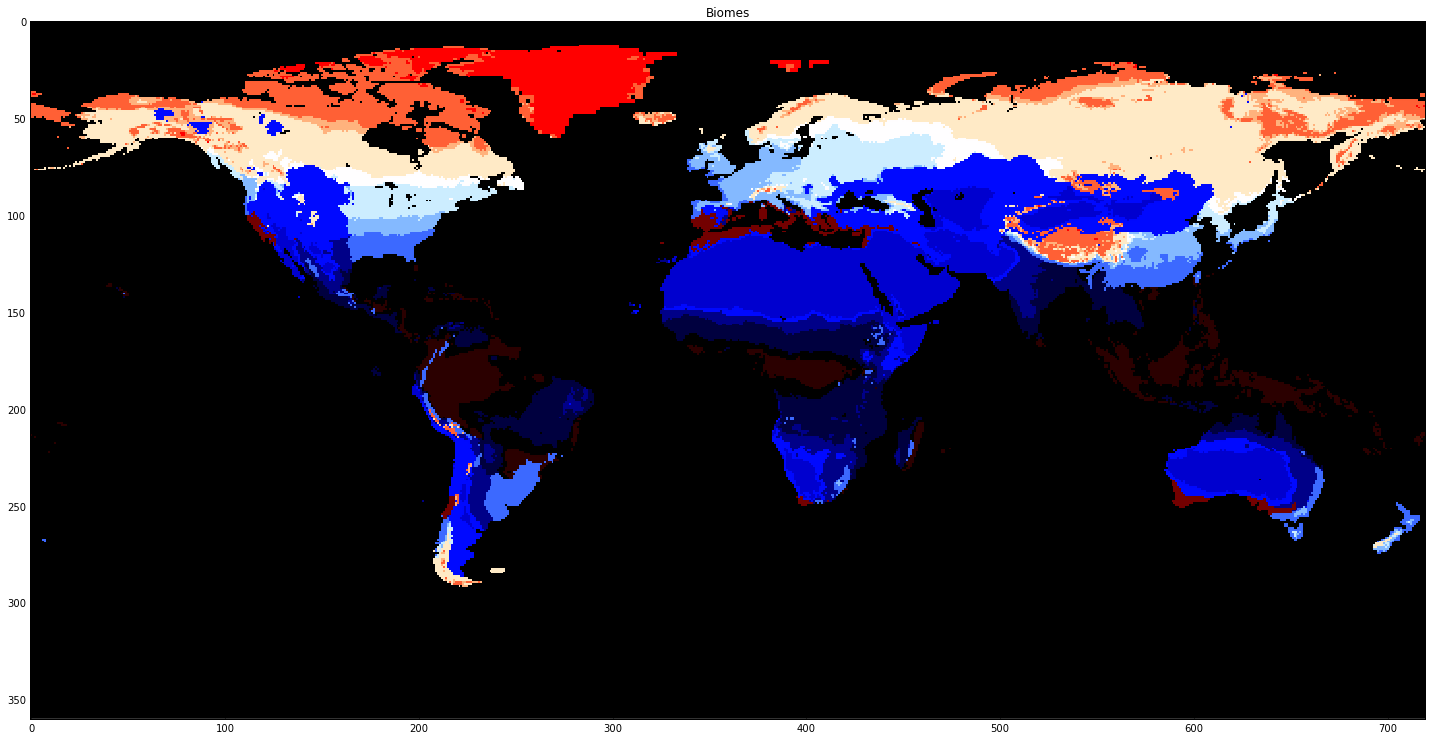

In [6]:
biomes_adf.plot()

### 4. Sample pseudo-absence pixels, taking into account all the distinct biomes that fall in the species region.

In [7]:
selected_layers, pseudo_absences = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[ 8  9 10 11 12 13 14 15 17 21]
There are 36793 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 987 unique pixels.


#### 4.1 Plot the biomes taken into account for sampling pseudo-absences, to get an idea

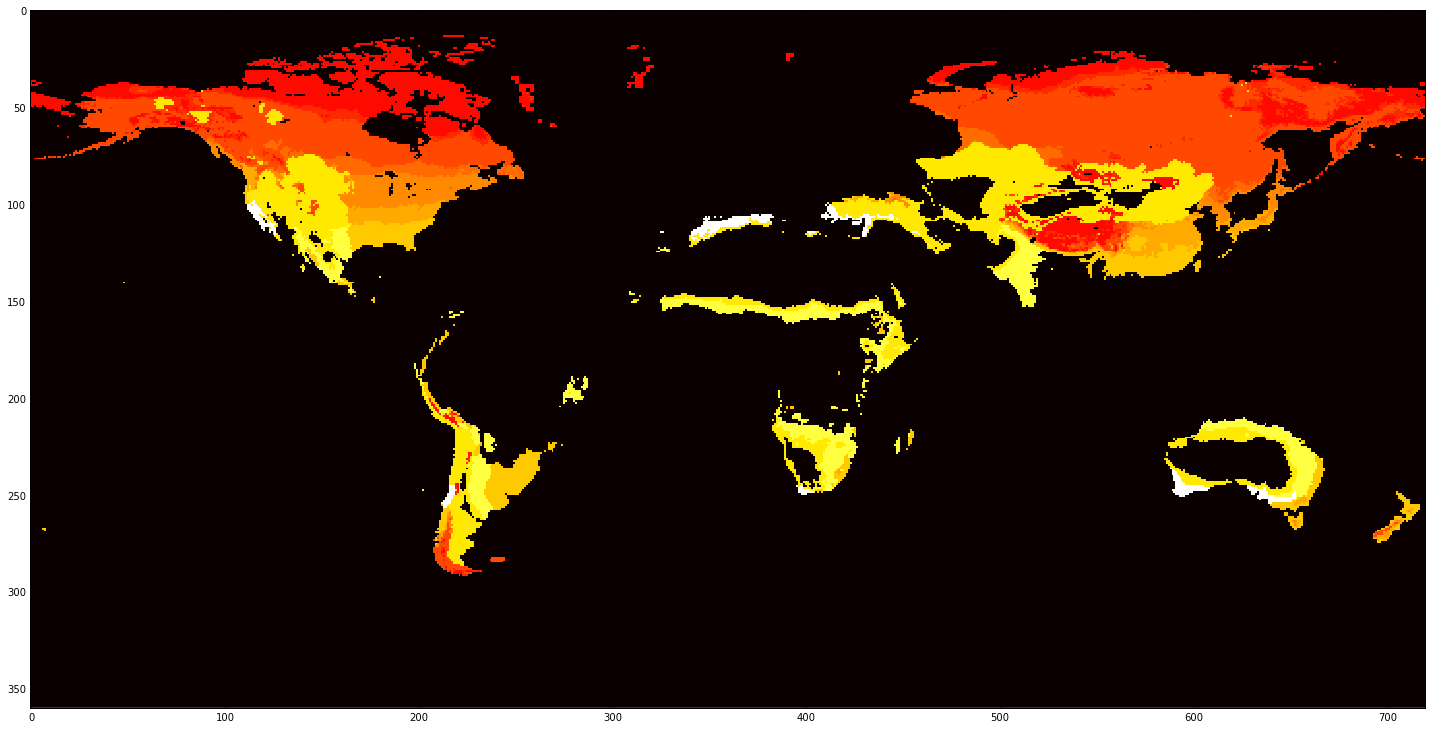

In [8]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers, cmap="hot", interpolation="none")

#### 4.2 Plot the sampled pseudo-absences, to get an idea

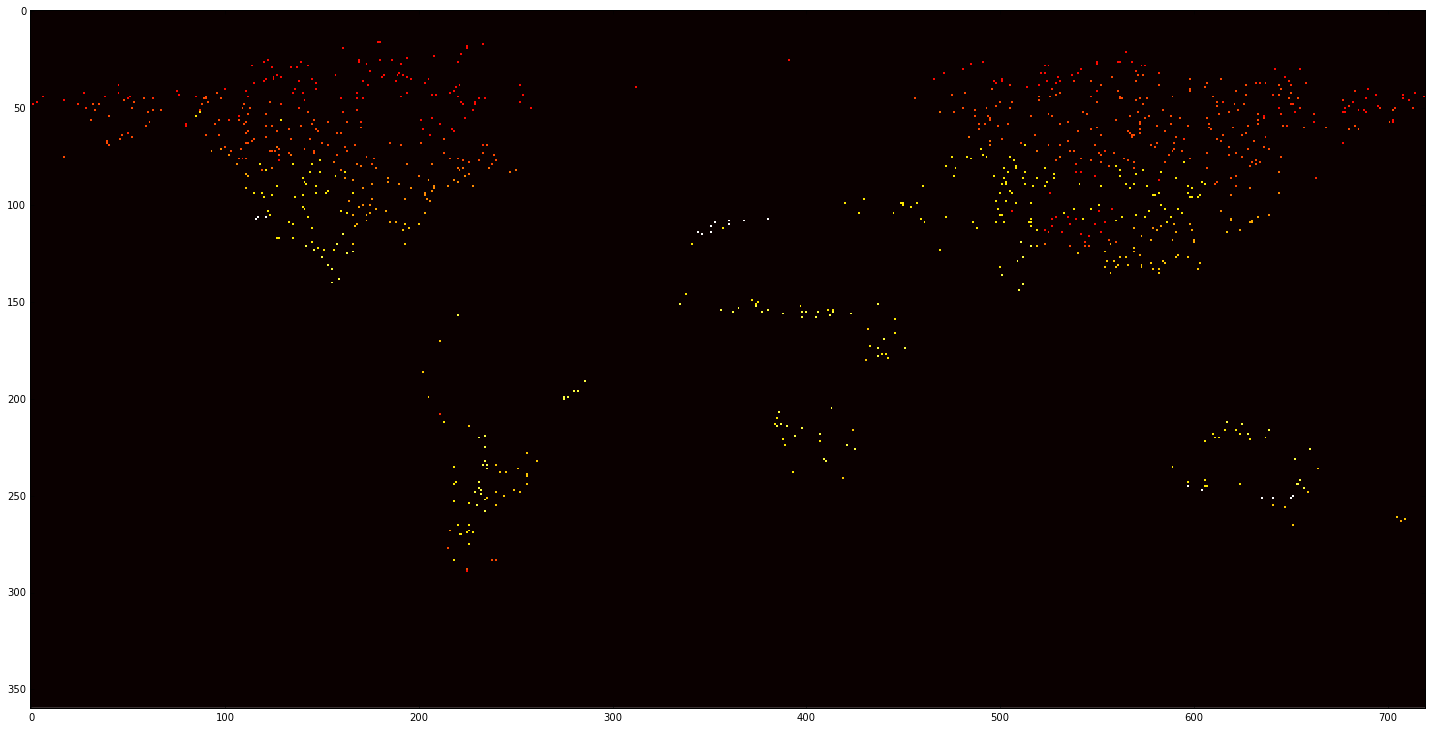

In [9]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences, cmap="hot", interpolation="none")

### 5. Construct a convenient dataframe for testing with different SDM models
For the Example 2 datasheet, all cells of a global raster map are needed, one pixel per row.

#### 5.1 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a "base" (zeroes) raster map. 

In [10]:
all_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=np.zeros_like(rasterized), filter_no_data_value=False)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Not filtering any no_data pixels.
Transformation to world coordinates completed.


In [11]:
all_coordinates

(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [12]:
base_dataframe = pd.DataFrame([all_coordinates[0], all_coordinates[1]]).T
base_dataframe.columns=['decimallatitude', 'decimallongitude']

In [13]:
base_dataframe.head()

,decimallatitude,decimallongitude
0,89.75,-179.75
1,89.75,-179.25
2,89.75,-178.75
3,89.75,-178.25
4,89.75,-177.75


In [14]:
base_dataframe.tail()

,decimallatitude,decimallongitude
259195,-89.75,177.75
259196,-89.75,178.25
259197,-89.75,178.75
259198,-89.75,179.25
259199,-89.75,179.75


#### 5.2 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a presences pixel map

In [15]:
presence_coordinates = salmo_trutta.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./salmo_trutta_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./salmo_trutta_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [16]:
presence_coordinates

(array([ 71.25,  71.25,  71.25, ...,  30.75,  30.25,  30.25]),
 array([ 23.75,  24.25,  24.75, ...,  79.25,  78.25,  78.75]))

In [17]:
presences_dataframe = pd.DataFrame([presence_coordinates[0], presence_coordinates[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[salmo_trutta.name_species] = 1 # fill presences with 1's
presences_dataframe.head()

,decimallatitude,decimallongitude,Salmo trutta
0,71.25,23.75,1
1,71.25,24.25,1
2,71.25,24.75,1
3,71.25,25.25,1
4,71.25,25.75,1


In [18]:
presences_dataframe.tail()

,decimallatitude,decimallongitude,Salmo trutta
6084,30.75,78.25,1
6085,30.75,78.75,1
6086,30.75,79.25,1
6087,30.25,78.25,1
6088,30.25,78.75,1


#### 5.3 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a pseudo_absences pixel map

In [19]:
pseudo_absence_coordinates = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [20]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates[0], pseudo_absence_coordinates[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[salmo_trutta.name_species] = 0

In [21]:
pseudo_absences_dataframe.head()

,decimallatitude,decimallongitude,Salmo trutta
0,81.75,-90.25,0
1,81.75,-89.75,0
2,81.25,-63.25,0
3,80.75,-67.25,0
4,80.25,-99.25,0


In [22]:
pseudo_absences_dataframe.tail()

,decimallatitude,decimallongitude,Salmo trutta
982,-51.75,-70.75,0
983,-51.75,-60.75,0
984,-51.75,-59.75,0
985,-54.25,-67.25,0
986,-54.75,-67.25,0


#### 5.4 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a minimum temperature pixel map

In [23]:
from iSDM.environment import ClimateLayer
water_min_layer =  ClimateLayer(file_path="../data/watertemp/min_wt_2000.tif") 
water_min_reader = water_min_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_min_coordinates = water_min_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/min_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/min_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.

In [24]:
water_min_coordinates

(array([ 89.75,  89.75,  89.75, ..., -89.75, -89.75, -89.75]),
 array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75]))

In [25]:
mintemp_dataframe = pd.DataFrame([water_min_coordinates[0], water_min_coordinates[1]]).T
mintemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_min_matrix = water_min_reader.read(1)
mintemp_dataframe['MinT'] = water_min_matrix.reshape(np.product(water_min_matrix.shape))
mintemp_dataframe.head()

,decimallatitude,decimallongitude,MinT
0,89.75,-179.75,-3.402823e+38
1,89.75,-179.25,-3.402823e+38
2,89.75,-178.75,-3.402823e+38
3,89.75,-178.25,-3.402823e+38
4,89.75,-177.75,-3.402823e+38


In [26]:
mintemp_dataframe.tail()

,decimallatitude,decimallongitude,MinT
259195,-89.75,177.75,-3.402823e+38
259196,-89.75,178.25,-3.402823e+38
259197,-89.75,178.75,-3.402823e+38
259198,-89.75,179.25,-3.402823e+38
259199,-89.75,179.75,-3.402823e+38


#### 5.5 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a maximum temperature pixel map

In [27]:
water_max_layer =  ClimateLayer(file_path="../data/watertemp/max_wt_2000.tif") 
water_max_reader = water_max_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_max_coordinates = water_max_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/max_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/max_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.

In [28]:
maxtemp_dataframe = pd.DataFrame([water_max_coordinates[0], water_max_coordinates[1]]).T
maxtemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_max_matrix = water_max_reader.read(1)
maxtemp_dataframe['MaxT'] = water_max_matrix.reshape(np.product(water_max_matrix.shape))
maxtemp_dataframe.head()

,decimallatitude,decimallongitude,MaxT
0,89.75,-179.75,-3.402823e+38
1,89.75,-179.25,-3.402823e+38
2,89.75,-178.75,-3.402823e+38
3,89.75,-178.25,-3.402823e+38
4,89.75,-177.75,-3.402823e+38


In [29]:
maxtemp_dataframe.tail()

,decimallatitude,decimallongitude,MaxT
259195,-89.75,177.75,-3.402823e+38
259196,-89.75,178.25,-3.402823e+38
259197,-89.75,178.75,-3.402823e+38
259198,-89.75,179.25,-3.402823e+38
259199,-89.75,179.75,-3.402823e+38


#### 5.6 Get arrays of coordinates (latitude/longitude) for each cell (middle point) in a mean temperature pixel map

In [30]:
water_mean_layer =  ClimateLayer(file_path="../data/watertemp/mean_wt_2000.tif") 
water_mean_reader = water_mean_layer.load_data()
# HERE: should we ignore cells with no-data values for temperature? They are set to a really big negative number
# for now we keep them, otherwise could be NaN
water_mean_coordinates = water_mean_layer.pixel_to_world_coordinates(filter_no_data_value=False)

Loaded raster data from ../data/watertemp/mean_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
No raster data provided, attempting to load default...
Loaded raster data from ../data/watertemp/mean_wt_2000.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 360,
 'nodata': -3.402823e+38,
 'transform': (-18

In [31]:
meantemp_dataframe = pd.DataFrame([water_mean_coordinates[0], water_mean_coordinates[1]]).T
meantemp_dataframe.columns=['decimallatitude', 'decimallongitude']
water_mean_matrix = water_mean_reader.read(1)
meantemp_dataframe['MeanT'] = water_mean_matrix.reshape(np.product(water_mean_matrix.shape))
meantemp_dataframe.head()

,decimallatitude,decimallongitude,MeanT
0,89.75,-179.75,-3.402823e+38
1,89.75,-179.25,-3.402823e+38
2,89.75,-178.75,-3.402823e+38
3,89.75,-178.25,-3.402823e+38
4,89.75,-177.75,-3.402823e+38


In [32]:
meantemp_dataframe.tail()

,decimallatitude,decimallongitude,MeanT
259195,-89.75,177.75,-3.402823e+38
259196,-89.75,178.25,-3.402823e+38
259197,-89.75,178.75,-3.402823e+38
259198,-89.75,179.25,-3.402823e+38
259199,-89.75,179.75,-3.402823e+38


In [33]:
# merge base with presences
merged = pd.merge(base_dataframe, presences_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

In [34]:
merged.head()

,decimallatitude,decimallongitude,Salmo trutta
0,89.75,-179.75,NaN
1,89.75,-179.25,NaN
2,89.75,-178.75,NaN
3,89.75,-178.25,NaN
4,89.75,-177.75,NaN


In [35]:
merged.tail()

,decimallatitude,decimallongitude,Salmo trutta
259195,-89.75,177.75,NaN
259196,-89.75,178.25,NaN
259197,-89.75,178.75,NaN
259198,-89.75,179.25,NaN
259199,-89.75,179.75,NaN


In [36]:
# merge based+presences with pseudo-absences
# merged2 = pd.merge(merged1, pseudo_absences_dataframe, on=["decimallatitude", "decimallongitude", salmo_trutta.name_species], how="outer")

merged = merged.combine_first(pseudo_absences_dataframe)

http://pandas.pydata.org/pandas-docs/stable/merging.html

For this, use the combine_first method.

Note that this method only takes values from the right DataFrame if they are missing in the left DataFrame. A related method, update, alters non-NA values inplace


In [37]:
merged.head()

,decimallatitude,decimallongitude,Salmo trutta
0,89.75,-179.75,0.0
1,89.75,-179.25,0.0
2,89.75,-178.75,0.0
3,89.75,-178.25,0.0
4,89.75,-177.75,0.0


In [38]:
merged.tail()

,decimallatitude,decimallongitude,Salmo trutta
259195,-89.75,177.75,NaN
259196,-89.75,178.25,NaN
259197,-89.75,178.75,NaN
259198,-89.75,179.25,NaN
259199,-89.75,179.75,NaN


In [39]:
# merge base+presences+pseudo-absences with min temperature
#merged3 = pd.merge(merged2, mintemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

merged = merged.combine_first(mintemp_dataframe)

In [40]:
merged.head()

,MinT,Salmo trutta,decimallatitude,decimallongitude
0,-3.402823e+38,0.0,89.75,-179.75
1,-3.402823e+38,0.0,89.75,-179.25
2,-3.402823e+38,0.0,89.75,-178.75
3,-3.402823e+38,0.0,89.75,-178.25
4,-3.402823e+38,0.0,89.75,-177.75


In [41]:
merged.tail()

,MinT,Salmo trutta,decimallatitude,decimallongitude
259195,-3.402823e+38,NaN,-89.75,177.75
259196,-3.402823e+38,NaN,-89.75,178.25
259197,-3.402823e+38,NaN,-89.75,178.75
259198,-3.402823e+38,NaN,-89.75,179.25
259199,-3.402823e+38,NaN,-89.75,179.75


In [42]:
# merged4 = pd.merge(merged3, maxtemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")
merged = merged.combine_first(maxtemp_dataframe)

In [43]:
merged.head()

,MaxT,MinT,Salmo trutta,decimallatitude,decimallongitude
0,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.75
1,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.25
2,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.75
3,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.25
4,-3.402823e+38,-3.402823e+38,0.0,89.75,-177.75


In [44]:
merged.tail()

,MaxT,MinT,Salmo trutta,decimallatitude,decimallongitude
259195,-3.402823e+38,-3.402823e+38,NaN,-89.75,177.75
259196,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.25
259197,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.75
259198,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.25
259199,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.75


In [45]:
# merged5 = pd.merge(merged4, meantemp_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")
merged = merged.combine_first(meantemp_dataframe)

In [46]:
merged.tail()

,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude
259195,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,177.75
259196,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.25
259197,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.75
259198,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.25
259199,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.75


In [47]:
merged.to_csv("../data/fish/selection/salmo_trutta.csv")

In [48]:
merged[merged['Salmo trutta']==0].shape[0] # should be equal to number of pseudo absences below

987

In [49]:
pseudo_absence_coordinates[0].shape[0]

987

In [50]:
merged[merged['Salmo trutta']==1].shape[0]  # should be equal to number of presences below

6089

In [51]:
presence_coordinates[0].shape[0]

6089

In [52]:
merged[merged['Salmo trutta'].isnull()].shape[0] # all that's left

252124

In [53]:
360 * 720 == merged[merged['Salmo trutta']==0].shape[0] + merged[merged['Salmo trutta']==1].shape[0] + merged[merged['Salmo trutta'].isnull()].shape[0]

True

In [54]:
# == all pixels in 360 x 720 matrix

### 6. Repeat with other species

In [55]:
# Download from Google Drive: https://drive.google.com/open?id=0B9cazFzBtPuCaW0wRkk2N0g5d1k
lepidomeda_mollispinis = IUCNSpecies(name_species='Lepidomeda mollispinis')
lepidomeda_mollispinis.load_shapefile("../data/fish/selection/lepidomeda_mollispinis")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/lepidomeda_mollispinis
The shapefile contains data on 1 species areas.


In [56]:
rasterized_lm = lepidomeda_mollispinis.rasterize(raster_file="./lepidomeda_mollispinis_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./lepidomeda_mollispinis_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


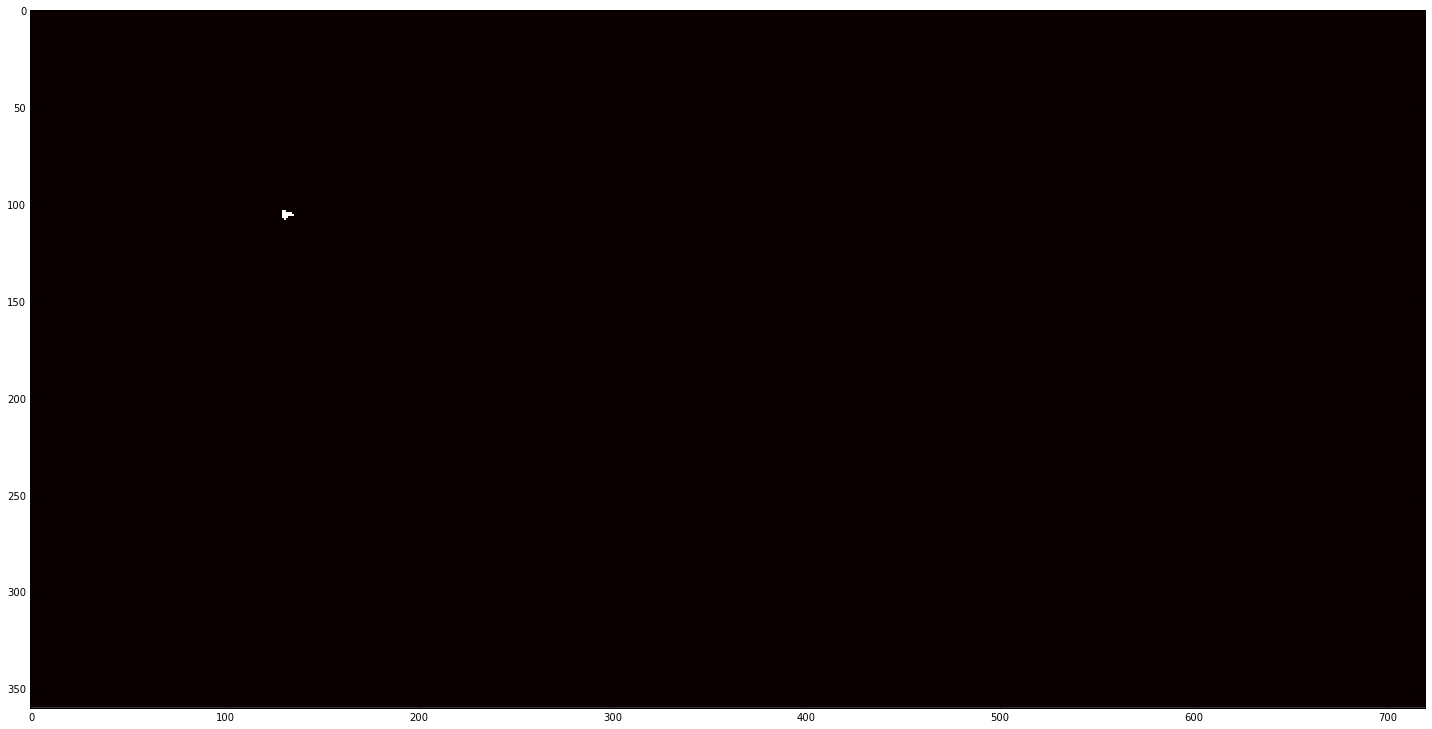

In [57]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized_lm, cmap="hot", interpolation="none")

In [58]:
selected_layers_lm, pseudo_absences_lm = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized_lm, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[15 16]
There are 16801 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 976 unique pixels.


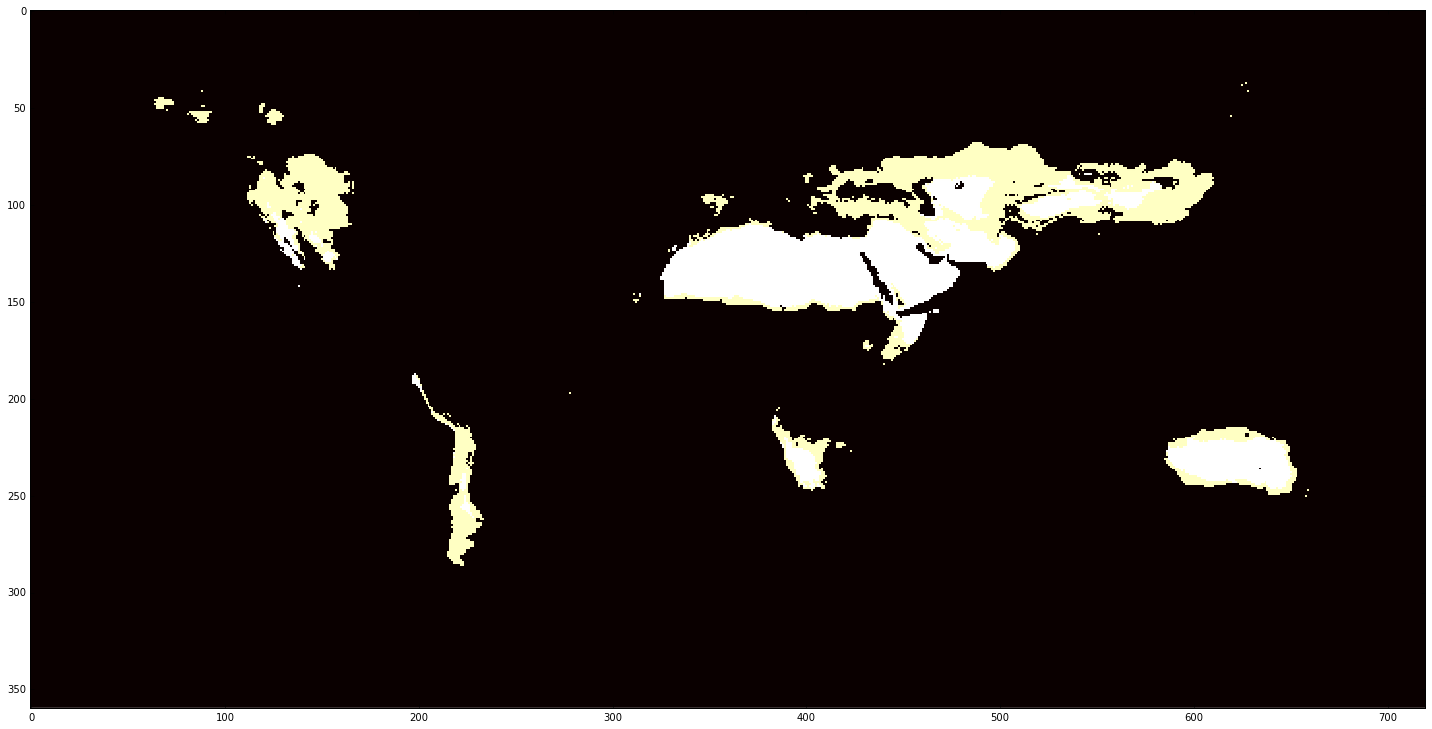

In [59]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers_lm, cmap="hot", interpolation="none")

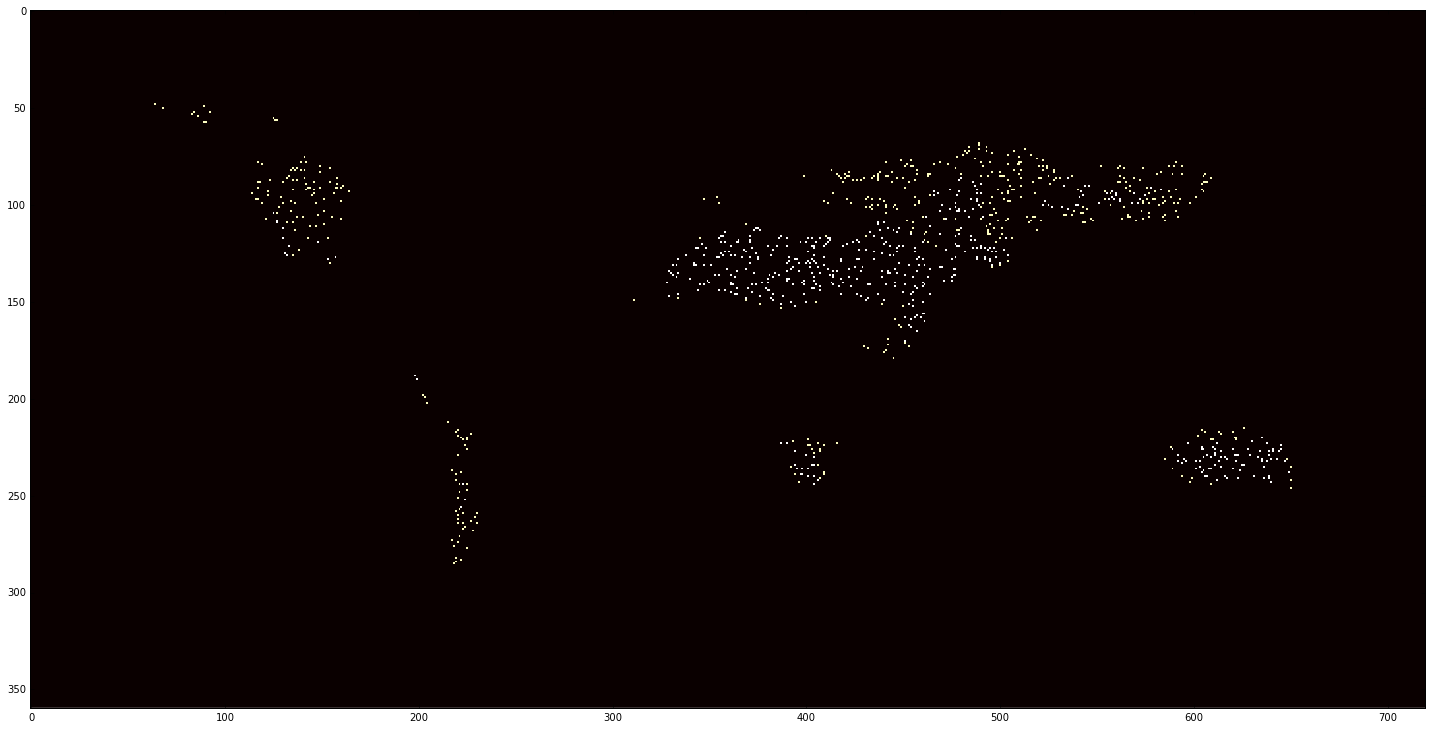

In [60]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences_lm, cmap="hot", interpolation="none")

In [61]:
presence_coordinates_lm = lepidomeda_mollispinis.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./lepidomeda_mollispinis_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./lepidomeda_mollispinis_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no

In [62]:
presences_dataframe = pd.DataFrame([presence_coordinates_lm[0], presence_coordinates_lm[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[lepidomeda_mollispinis.name_species] = 1 # fill presences with 1's
presences_dataframe.head()

,decimallatitude,decimallongitude,Lepidomeda mollispinis
0,38.25,-114.75,1
1,38.25,-114.25,1
2,37.75,-114.75,1
3,37.75,-114.25,1
4,37.75,-113.75,1


In [63]:
presences_dataframe.tail()

,decimallatitude,decimallongitude,Lepidomeda mollispinis
12,37.25,-112.25,1
13,36.75,-114.75,1
14,36.75,-114.25,1
15,36.75,-113.75,1
16,36.25,-114.25,1


In [64]:
pseudo_absence_coordinates_lm = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences_lm)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [65]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates_lm[0], pseudo_absence_coordinates_lm[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[lepidomeda_mollispinis.name_species] = 0

In [66]:
pseudo_absences_dataframe.head()

,decimallatitude,decimallongitude,Lepidomeda mollispinis
0,65.75,-147.75,0
1,65.25,-135.25,0
2,64.75,-145.75,0
3,63.75,-137.75,0
4,63.75,-133.75,0


In [67]:
pseudo_absences_dataframe.tail()

,decimallatitude,decimallongitude,Lepidomeda mollispinis
971,-48.75,-67.25,0
972,-51.25,-70.25,0
973,-51.75,-68.75,0
974,-52.25,-70.25,0
975,-52.75,-70.75,0


In [68]:
merged1 = pd.merge(merged, presences_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

In [69]:
merged1.tail()

,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude,Lepidomeda mollispinis
259195,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,177.75,NaN
259196,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.25,NaN
259197,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.75,NaN
259198,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.25,NaN
259199,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.75,NaN


In [70]:
merged1 = merged1.combine_first(pseudo_absences_dataframe)

In [71]:
merged1.tail()

,Lepidomeda mollispinis,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude
259195,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,177.75
259196,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.25
259197,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.75
259198,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.25
259199,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.75


In [72]:
merged1['Lepidomeda mollispinis'].unique()

array([  0.,  nan,   1.])

In [73]:
merged1[merged1['Lepidomeda mollispinis']==0].shape # pseudo-absences

(976, 7)

In [74]:
merged1[merged1['Lepidomeda mollispinis']==1].shape # presences

(17, 7)

In [75]:
merged1[merged1['Lepidomeda mollispinis'].isnull()].shape

(258207, 7)

In [76]:
merged1[merged1['Lepidomeda mollispinis'].isnull()].shape[0] + merged1[merged1['Lepidomeda mollispinis']==1].shape[0] + merged1[merged1['Lepidomeda mollispinis']==0].shape[0]

259200

In [77]:
salmo_trutta.get_data().shape_area.sum()

1300.4651633274541

In [78]:
lepidomeda_mollispinis.get_data().shape_area.sum()

1.8861804794299999

Third species.... (largest IUCN area, also plenty of occurrences in GBIF)

In [79]:
# Download from Google drive: https://drive.google.com/open?id=0B9cazFzBtPuCamEwWlZxV3lBZmc
esox_lucius = IUCNSpecies(name_species='Esox lucius')
esox_lucius.load_shapefile("../data/fish/selection/esox_lucius/")

Enabled Shapely speedups for performance.
Loading data from: ../data/fish/selection/esox_lucius/
The shapefile contains data on 6 species areas.


In [80]:
rasterized_el = esox_lucius.rasterize(raster_file="./esox_lucius_full.tif", pixel_size=0.5, all_touched=True)

RASTERIO: Data rasterized into file ./esox_lucius_full.tif 
RASTERIO: Resolution: x_res=720 y_res=360


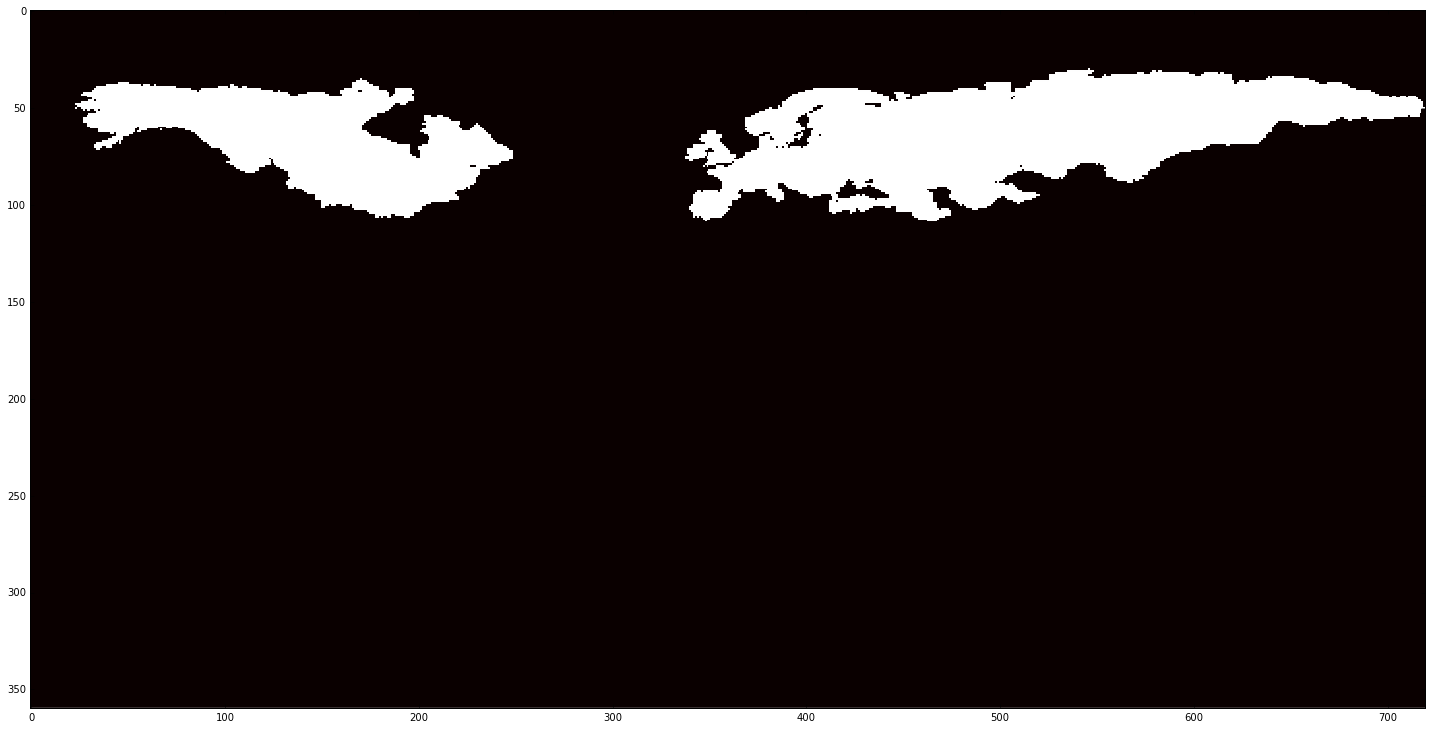

In [81]:
plt.figure(figsize=(25,20))
plt.imshow(rasterized_el, cmap="hot", interpolation="none")

In [82]:
selected_layers_el, pseudo_absences_el = biomes_adf.sample_pseudo_absences(species_raster_data=rasterized_el, number_of_pseudopoints=1000)

Succesfully loaded existing raster data from ../data/rebioms/w001001.adf.
Sampling 1000 pseudo-absence points from environmental layer.
The following unique (pixel) values will be taken into account for sampling pseudo-absences
[ 7  8  9 10 11 12 13 14 15 16 17 21]
There are 31022 pixels to sample from...
Filling 1000 random pixel positions...
Sampled 988 unique pixels.


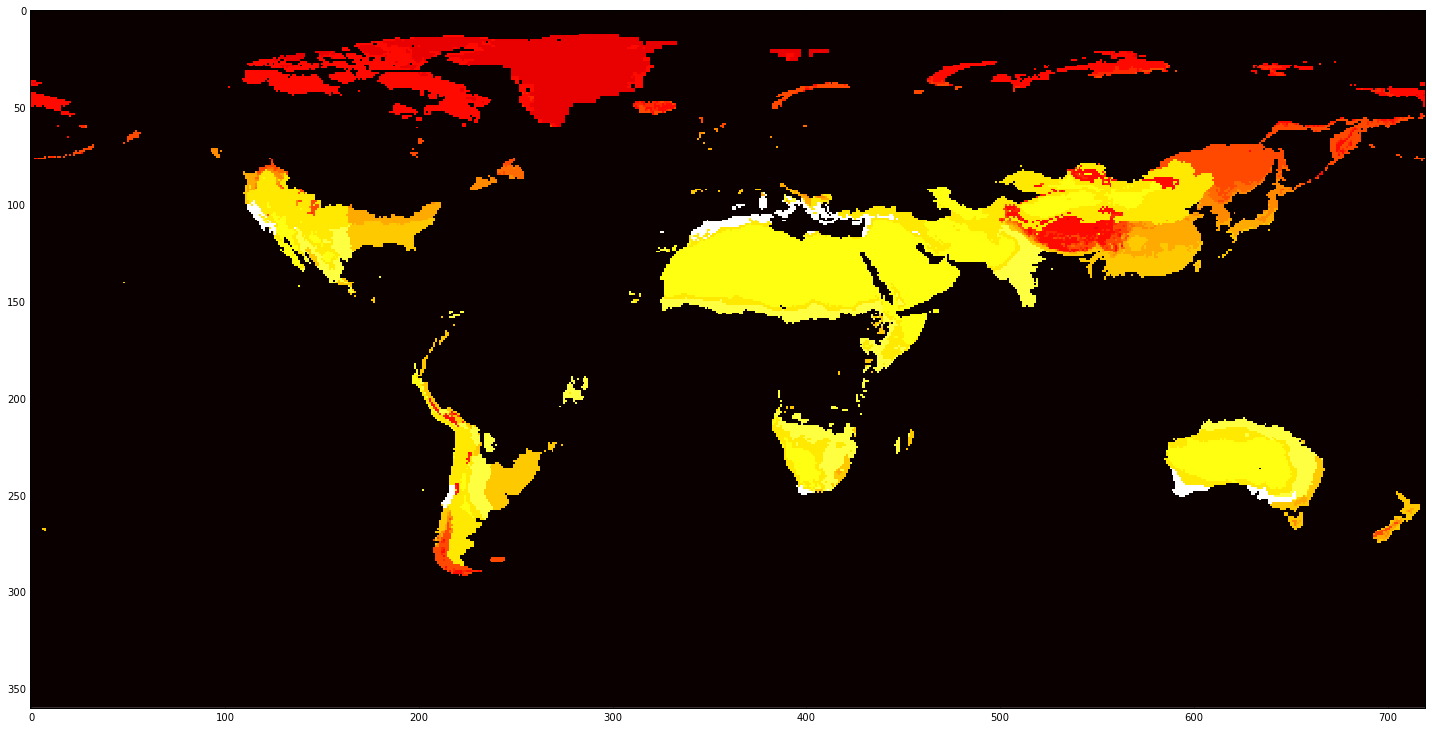

In [83]:
plt.figure(figsize=(25,20))
plt.imshow(selected_layers_el, cmap="hot", interpolation="none")

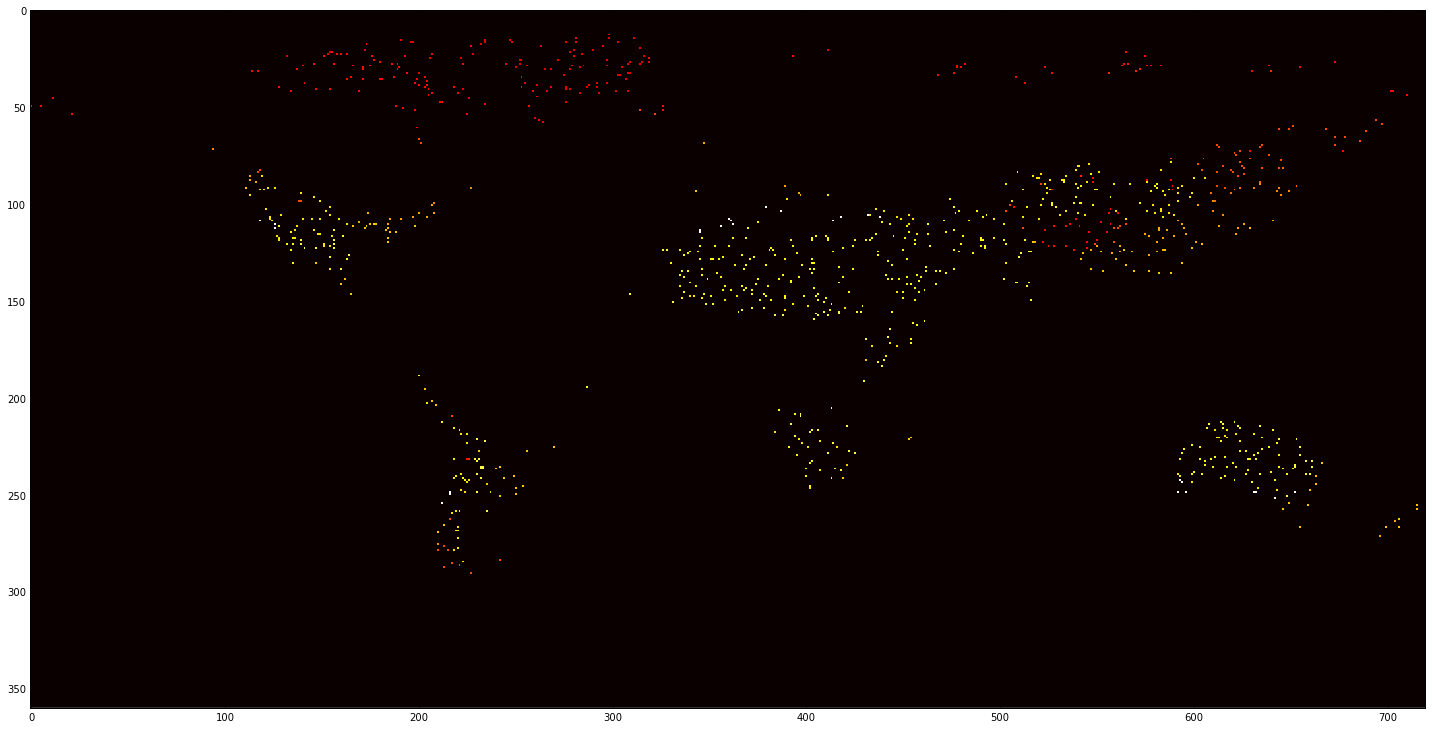

In [84]:
plt.figure(figsize=(25,20))
plt.imshow(pseudo_absences_el, cmap="hot", interpolation="none")

In [85]:
presence_coordinates_el = esox_lucius.pixel_to_world_coordinates()

No raster data provided, attempting to load default...
Loaded raster data from ./esox_lucius_full.tif 
Driver name: GTiff 
Metadata: {'affine': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 90.0),
 'count': 1,
 'crs': {'init': 'epsg:4326'},
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 360,
 'nodata': 0.0,
 'transform': (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5),
 'width': 720} 
Resolution: x_res=720 y_res=360.
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0) 
Coordinate reference system: {'init': 'epsg:4326'} 
Affine transformation: (-180.0, 0.5, 0.0, 90.0, 0.0, -0.5) 
Number of layers: 1 
Dataset loaded. Use .read() or .read_masks() to access the layers.
Succesfully loaded existing raster data from ./esox_lucius_full.tif.
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.


In [86]:
presences_dataframe = pd.DataFrame([presence_coordinates_el[0], presence_coordinates_el[1]]).T
presences_dataframe.columns=['decimallatitude', 'decimallongitude']
presences_dataframe[esox_lucius.name_species] = 1 # fill presences with 1's
presences_dataframe.head()

,decimallatitude,decimallongitude,Esox lucius
0,74.75,93.25,1
1,74.25,87.75,1
2,74.25,88.25,1
3,74.25,88.75,1
4,74.25,89.25,1


In [87]:
pseudo_absence_coordinates_el = biomes_adf.pixel_to_world_coordinates(raster_data=pseudo_absences_el)

Transforming to world coordinates...
Affine transformation T0:
 |-0.50, 0.00, 90.00|
| 0.00, 0.50,-180.00|
| 0.00, 0.00, 1.00| 
Raster data shape: (360, 720) 
Affine transformation T1:
 |-0.50, 0.00, 89.75|
| 0.00, 0.50,-179.75|
| 0.00, 0.00, 1.00| 
Filtering out no_data pixels.
Transformation to world coordinates completed.


In [88]:
pseudo_absences_dataframe = pd.DataFrame([pseudo_absence_coordinates_el[0], pseudo_absence_coordinates_el[1]]).T
pseudo_absences_dataframe.columns=['decimallatitude', 'decimallongitude']
pseudo_absences_dataframe[esox_lucius.name_species] = 0
pseudo_absences_dataframe.head()

,decimallatitude,decimallongitude,Esox lucius
0,83.75,-30.75,0
1,82.75,-39.25,0
2,82.75,-30.75,0
3,82.75,-24.25,0
4,82.25,-84.25,0


In [89]:
merged2 = pd.merge(merged1, presences_dataframe, on=["decimallatitude", "decimallongitude"], how="outer")

In [90]:
merged2.head()

,Lepidomeda mollispinis,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude,Esox lucius
0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.75,NaN
1,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.25,NaN
2,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.75,NaN
3,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.25,NaN
4,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-177.75,NaN


In [91]:
merged2 = merged2.combine_first(pseudo_absences_dataframe)

In [92]:
merged2.head()

,Esox lucius,Lepidomeda mollispinis,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude
0,0.0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.75
1,0.0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-179.25
2,0.0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.75
3,0.0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-178.25
4,0.0,0.0,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.0,89.75,-177.75


In [93]:
merged2['Esox lucius'].unique()

array([  0.,  nan,   1.])

In [94]:
merged2[merged2['Esox lucius']==0].shape # pseudo-absences

(988, 8)

In [95]:
merged2[merged2['Esox lucius']==1].shape # presences

(23715, 8)

In [96]:
merged2[merged2['Esox lucius'].isnull()].shape

(234497, 8)

In [97]:
merged2[merged2['Esox lucius'].isnull()].shape[0] + merged2[merged2['Esox lucius']==1].shape[0] + merged2[merged2['Esox lucius']==0].shape[0]

259200

In [98]:
merged2.tail()

,Esox lucius,Lepidomeda mollispinis,MaxT,MeanT,MinT,Salmo trutta,decimallatitude,decimallongitude
259195,NaN,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,177.75
259196,NaN,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.25
259197,NaN,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,178.75
259198,NaN,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.25
259199,NaN,NaN,-3.402823e+38,-3.402823e+38,-3.402823e+38,NaN,-89.75,179.75


In [99]:
# rearange columns (nothing critical)

In [100]:
cols = merged2.columns.values
cols1 = [cols[6], cols[7], cols[0], cols[1], cols[5], cols[4], cols[2], cols[3]]
merged2 = merged2[cols1]

In [101]:
merged2.to_csv("../data/fish/selection/dataframe2.csv")